In [81]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
sns.set_style("whitegrid")
sns.set_palette("Set2", 8)

## Load Data
Define a function that imports all the data from the provided csv files

In [2]:
csv_paths = glob.glob("data/*.csv")
csv_filenames = [os.path.splitext(os.path.basename(x))[0] for x in csv_paths]

def load_data_from_csv():
    """Loads the csv files to pandas DataFrames and saves
    them in a dictionary with their filenames as keys"""
    data = dict()
    for csv_filename, csv_path in zip(csv_filenames, csv_paths):
        data[csv_filename] = pd.read_csv(csv_path)
    return data

# Load the data to a Dictionary
data = load_data_from_csv()

Inspect the data, the schema is shown below:

<img src="docs/schema.png">

First replace the chinese brands with their english names

In [3]:
# Join chinese brand names to their english equivalents
phone_brand_device_model = pd.merge(data["phone_brand_device_model"],
                                    data["chinese_to_english_brand"],
                                    left_on="phone_brand", right_on="chinese_brand", how="left")

# Fill nans for brands already in english
phone_brand_device_model["brand"] =\
    phone_brand_device_model["brand"].where(phone_brand_device_model["brand"].str.isalpha(),
                                                    phone_brand_device_model["phone_brand"].str.lower())

# We will just work with device brand for the time being
device_data = phone_brand_device_model[["device_id", "brand", "device_model"]]
device_data

,device_id,brand,device_model
0,-8890648629457979026,xiaomi,红米
1,1277779817574759137,xiaomi,MI 2
2,5137427614288105724,samsung,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,samsung,Galaxy Note 2
...,...,...,...
187240,7979541072208733273,xiaomi,MI 4
187241,-187404680852357705,xiaomi,红米2
187242,-2718274279595622821,xiaomi,MI 3
187243,3098391762071677791,vivo,X1


Calculate the frequency of each brand and device model in the dataset

In [4]:
brand_counts = device_data.groupby(["brand"], as_index=False)[["device_id"]].count().rename(columns={"device_id":"brand_count"})
model_counts = device_data.groupby(["device_model"], as_index=False)[["device_id"]].count().rename(columns={"device_id":"model_count"})

Join the counts back to the device table

In [5]:
top_10_brands = brand_counts.sort_values(by="brand_count", ascending=False).iloc[:10,:]
top_10_models = model_counts.sort_values(by="model_count", ascending=False).iloc[:10,:]

<AxesSubplot:xlabel='brand_count', ylabel='brand'>

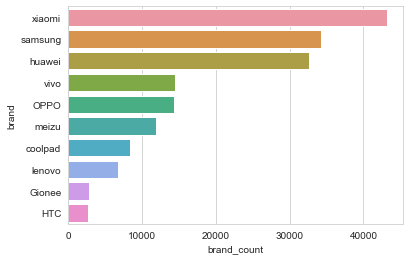

In [56]:
sns.barplot(x="brand_count", y="brand", data=top_10_brands)

In [7]:
device_data = device_data.merge(brand_counts, on="brand", how="left").merge(model_counts, on="device_model", how="left")

In [9]:
device_data

,device_id,brand,device_model,brand_count,model_count
0,-8890648629457979026,xiaomi,红米,43210,2438
1,1277779817574759137,xiaomi,MI 2,43210,1312
2,5137427614288105724,samsung,Galaxy S4,34286,4059
3,3669464369358936369,SUGAR,时尚手机,11,9
4,-5019277647504317457,samsung,Galaxy Note 2,34286,3993
...,...,...,...,...,...
187240,7979541072208733273,xiaomi,MI 4,43210,4798
187241,-187404680852357705,xiaomi,红米2,43210,2090
187242,-2718274279595622821,xiaomi,MI 3,43210,5712
187243,3098391762071677791,vivo,X1,14395,135


In [10]:
print(f'There are {len(device_data["device_id"].unique())} unique devices in the device data')
# Get rid of duplicates in the device data
device_data_cln = device_data.drop_duplicates("device_id")
print(len(device_data_cln))

There are 186716 unique devices in the device data
186716


There are 6 age group categories for each gender

In [11]:
data["gender_age_train"]["group"].sort_values().unique()

array(['F23-', 'F24-26', 'F27-28', 'F29-32', 'F33-42', 'F43+', 'M22-',
       'M23-26', 'M27-28', 'M29-31', 'M32-38', 'M39+'], dtype=object)

We'll proceed to join the device brand data to the train data

In [14]:
combined_data = data["gender_age_train"]
print(len(combined_data))
combined_data = pd.merge(combined_data, device_data_cln, on="device_id", how="left")
combined_data

74645


,device_id,gender,age,group,brand,device_model,brand_count,model_count
0,-8076087639492063270,M,35,M32-38,xiaomi,MI 2,43210,1312
1,-2897161552818060146,M,35,M32-38,xiaomi,MI 2,43210,1312
2,-8260683887967679142,M,35,M32-38,xiaomi,MI 2,43210,1312
3,-4938849341048082022,M,30,M29-31,xiaomi,红米note,43210,7358
4,245133531816851882,M,30,M29-31,xiaomi,MI 3,43210,5712
...,...,...,...,...,...,...,...,...
74640,4682031842235089751,M,30,M29-31,xiaomi,MI 3,43210,5712
74641,-9178703742877135986,M,30,M29-31,xiaomi,MI 3,43210,5712
74642,180946546684162312,M,20,M22-,xiaomi,红米note,43210,7358
74643,1390702386071991851,M,37,M32-38,huawei,Ascend P8,32564,929


In [26]:
total_male = combined_data["gender"].loc[combined_data["gender"]=="M"].count()
total_female = combined_data["gender"].loc[combined_data["gender"]=="F"].count()

Count brand and device model names for each gender and then normalise them

In [80]:
brand_counts_gender = combined_data.groupby(["gender", "brand"], as_index=False)[["device_id"]].count().rename(columns={"device_id":"brand_count"})
model_counts_gender = combined_data.groupby(["gender", "device_model"], as_index=False)[["device_id"]].count().rename(columns={"device_id":"model_count"})

In [82]:
brand_counts_gender

,gender,brand,brand_count
0,F,AUX,2
1,F,Bifer,9
2,F,CUBE,25
3,F,Changhong,1
4,F,Cong,3
...,...,...,...
204,M,虾米,1
205,M,西门子,1
206,M,飞利浦,1
207,M,首云,1


In [ ]:
brand_counts_gender["norm_count"] = np.where(brand_counts_gender["gender"]=="M", brand_counts_gender["brand_count"]/total_male, brand_counts_gender["brand_count"]/total_female)

In [32]:
brand_counts_gender

,gender,brand,brand_count,norm_count
0,F,AUX,2,0.000075
1,F,Bifer,9,0.000337
2,F,CUBE,25,0.000935
3,F,Changhong,1,0.000037
4,F,Cong,3,0.000112
...,...,...,...,...
204,M,虾米,1,0.000021
205,M,西门子,1,0.000021
206,M,飞利浦,1,0.000021
207,M,首云,1,0.000021


In [35]:
top_10_brands_gender = brand_counts_gender.sort_values("norm_count",ascending = False).groupby("gender").head(10)

In [37]:
top_10_brands_gender.sort_values(by=["gender", "brand"])

,gender,brand,brand_count,norm_count
5,F,Gionee,402,0.015033
6,F,HTC,320,0.011967
15,F,OPPO,2571,0.096144
35,F,coolpad,1079,0.040350
48,F,huawei,4244,0.158708
53,F,lenovo,893,0.033394
57,F,meizu,1302,0.048689
72,F,samsung,5431,0.203096
74,F,vivo,2651,0.099136
78,F,xiaomi,5918,0.221308


<AxesSubplot:xlabel='norm_count', ylabel='brand'>

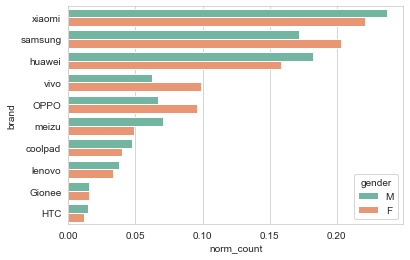

In [57]:
sns.barplot(x="norm_count", y="brand", hue="gender", data=top_10_brands_gender)

In [79]:
top_10_brands_gender

,gender,brand,brand_count,norm_count
182,M,xiaomi,11381,0.237579
78,F,xiaomi,5918,0.221308
72,F,samsung,5431,0.203096
151,M,huawei,8716,0.181947
175,M,samsung,8238,0.171969
48,F,huawei,4244,0.158708
74,F,vivo,2651,0.099136
15,F,OPPO,2571,0.096144
160,M,meizu,3397,0.070913
114,M,OPPO,3212,0.067051


In [76]:
top_10_brands_gender

,gender,brand,brand_count,norm_count
182,M,xiaomi,11381,0.237579
78,F,xiaomi,5918,0.221308
72,F,samsung,5431,0.203096
151,M,huawei,8716,0.181947
175,M,samsung,8238,0.171969
48,F,huawei,4244,0.158708
74,F,vivo,2651,0.099136
15,F,OPPO,2571,0.096144
160,M,meizu,3397,0.070913
114,M,OPPO,3212,0.067051


In [77]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectoriser = TfidfVectorizer(min_df=1)
vectors = vectoriser.fit_transform(top_10_brands_gender)

feature_names = vectoriser.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)

In [ ]:
combined_data["gender"].value_counts().plot(kind='barh')

In [ ]:
# Plot the gender distribution for the top 5 brands
brands = combined_data["brand"].value_counts().index[:5]
c = combined_data[combined_data["brand"].isin(brands)]
g = sns.FacetGrid(c, hue='gender', col='brand',col_wrap=3, aspect=2, xlim=(15,60))
g.map(sns.distplot, 'age', bins=np.arange(15,70)+0.5)

In [ ]:
# Plot the gender distribution for the top 10 models
plt.rcParams['font.sans-serif'] = ['Source Han Sans TW', 'sans-serif']
model = combined_data["device_model"].value_counts().index[:10]
c = combined_data[combined_data["device_model"].isin(model)]
g = sns.FacetGrid(c, hue='gender', col='device_model',col_wrap=3, aspect=2, xlim=(15,60))
g.map(sns.distplot, 'age', bins=np.arange(15,70)+0.5)